In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import h5py
from matplotlib import colors
import matplotlib.pyplot as plt
import multiprocessing
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import ssm
from ssm.util import find_permutation
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from ld_utils import slds_compute_eigs
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save

In [3]:
results_dir = "/home/adameisen/Documents/MIT/code/ChaoticConsciousness/__data__/propofol/SLDS/SLDS_Mary-Anesthesia-20160809-01_latent_32_window_5_stride_30_Nov-30-2021_2041"

In [4]:
session = os.path.basename(results_dir).split('_')[1]

# Load Neural Data

In [19]:
filename = fr'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/{session}.mat'

print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

f = h5py.File(filename, 'r')
airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 120.37 seconds)


# Load Results

## Compute Eigs and Predictions

In [12]:
run_params = load(os.path.join(results_dir, 'run_params'))
results = []
for i, f in enumerate(tqdm([f for f in os.listdir(results_dir) if f.startswith('start')])):
    row = pd.Series(load(os.path.join(results_dir, f)))
    
    disc_states, counts = np.unique(row.disc_states, return_counts=True)
    avg_crit = 0
    for disc_state, count in zip(disc_states, counts):
        avg_crit += (count/np.sum(counts))*row.criticality_inds[disc_state].mean()
    
    
    results.append({'avg_criticality': avg_crit, 'start_time': row.start_time})
    
results = pd.DataFrame(results)
results = results.sort_values('start_time', ignore_index=True)

  0%|          | 0/237 [00:00<?, ?it/s]

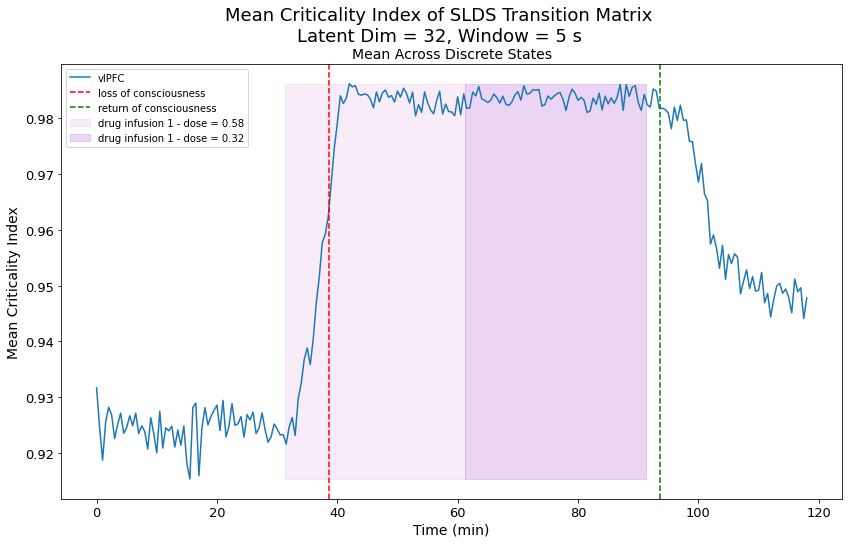

In [20]:
fig = plt.figure(figsize=(14, 8))

ax = plt.gca()
start_times = results.start_time/60
# mean_eigs = np.array([mat.mean() for mat in results.criticality_inds])
ax.plot(start_times, results.avg_criticality, label='vlPFC')
ax.set_xlabel('Time (min)', fontsize=14)
ax.set_ylabel('Mean Criticality Index', fontsize=14)
ax.set_title("Mean Across Discrete States", fontsize=14)
min_val = results.avg_criticality.min()
max_val = results.avg_criticality.max()
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], run_params['stride'])/60, 
                        min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], run_params['stride'])/60, 
                        min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][1]}")

plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
ax.legend()
plt.suptitle(f"Mean Criticality Index of SLDS Transition Matrix\nLatent Dim = {run_params['latent_dim']}, Window = {run_params['window']} s", fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=13)
plt.show()

In [ ]:
unit_indices = run_params['unit_indices']
length = run_params['length']
n_samp = 10
T_samp = 25

interval = 5 # number of windows to use
indices = np.arange(len(results) - 1)
indices = [i for i in indices if i % interval == 0]

start_times = np.zeros(len(indices))

predictions = np.zeros((len(indices), 1, T_samp, len(unit_indices)))
# prediction_mse = np.zeros((len(indices), 1, T_samp))
for num, index in enumerate(tqdm(indices)):
    row = results.iloc[index]
    start_times[num] = row.start_time
    
    slds = row.slds
    start_step = row.start_step
#     ts = [results.iloc[index + 1].start_step]
    ts = [results.iloc[index].start_step]
#     ts = [results.iloc[index + 800].start_step]
#     print(results.iloc[index + 800].start_time)

    for i, t in enumerate(ts):
#         elbo_test,q_test= slds.approximate_posterior(lfp[t-length+1:t+1, unit_indices], num_iters=10, verbose=False) 
#         x_test=q_test.mean_continuous_states[0][-1:]
#         z_test=np.argmax(q_test.mean_discrete_states[0][-1:],axis=1)
        
        elbo_test,q_test= slds.approximate_posterior(lfp[t:t+length, unit_indices], num_iters=10, verbose=False) 
        x_test=q_test.mean_continuous_states[0][0:1]
        z_test=np.argmax(q_test.mean_discrete_states[0][0:1],axis=1)
        
        for n in range(n_samp):
            [z_pred,x_pred,y_pred]=slds.sample(T_samp, prefix=(z_test,x_test,lfp[t:t+1, unit_indices]))
    #         y_pred_current = slds.smooth(x_test, lfp[t:t+1, unit_indices])
            predictions[num][i] += y_pred
#             prediction_mse[num][i] += ((y_pred - lfp[t+1:t + T_samp + 1, unit_indices])**2).mean(axis=1)

        predictions[num] /= n_samp
        prediction_mse[num] /= n_samp

In [ ]:
plt.figure(figsize=(10, 5))
index_num = 0
unit_num = 0

# t = results.iloc[indices[index_num] + 1].start_step
t = results.iloc[indices[index_num]].start_step
plt.plot(np.concatenate([lfp[t:t+1, unit_indices[unit_num]], predictions[index_num][0][:, unit_num]]), label='predicted')
# plt.plot(y_pred[:, unit_num])
plt.plot(lfp[t:t + T_samp + 1, unit_indices[unit_num]], label='true')
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('LFP (mV)', fontsize=14)
ax = plt.gca()
ax.tick_params(labelsize=13)
plt.legend()
plt.show()